# 環境構築

Tensorflow Object Detection APIのインストールガイド<br>
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

In [0]:
# GPUの確認
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
# 必要ライブラリのインストール
!apt-get -y install protobuf-compiler python-pil python-lxml python-tk
!pip install jupyter
!pip install matplotlib

In [0]:
# Tensorflow Object Detecionのモデルをgitclone
!git clone https://github.com/tensorflow/models.git

In [0]:
# PATH設定
import sys
sys.path.append('/content/models/research')
sys.path.append('/content/models/research/slim')
sys.path.append('/content/models/research/object_detection/')

In [0]:
#  ディレクトリ変更
import os
os.chdir("/content/models/research/")

In [0]:
# Protobufライブラリのコンパイル(モデル設定と学習に使用)
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
# Tensorflowモデルのビルドとインストール
!python setup.py build
!python setup.py install

In [0]:
# ディレクトリ変更
os.chdir("/content/models/research/slim")

In [0]:
# Tensorflow-Slimモデルのビルドとインストール
!python setup.py build
!python setup.py install

In [0]:
# ディレクトリ変更
os.chdir("/content/models/research/")

In [48]:
# Tensorflow Object Detection APIがインストールされたことの確認
!python object_detection/builders/model_builder_test.py

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
..............
----------------------------------------------------------------------
Ran 14 tests in 0.070s

OK


# 学習済みモデル読み込み

*DetectionModel*のページから「ssd_mobilenet_v1_coco」のモデルをダウンロード<br>
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

In [55]:
# SSD(mobilenet)の学習済みモデルをダウンロード（cocoデータセットを用いて学習)
os.chdir('/content/models/research/object_detection/')
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz

--2018-03-31 10:13:14--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128048406 (122M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz.1’

ssd_mobilenet_v1_co 100%[===================>] 122.12M   129MB/s    in 0.9s    

2018-03-31 10:13:15 (129 MB/s) - ‘ssd_mobilenet_v1_coco_11_06_2017.tar.gz.1’ saved [128048406/128048406]



In [56]:
# 圧縮ファイルを解凍
!tar -xzvf ssd_mobilenet_v1_coco_11_06_2017.tar.gz

ssd_mobilenet_v1_coco_11_06_2017/
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.index
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.meta
ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_11_06_2017/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_11_06_2017/graph.pbtxt


In [57]:
# モデルファイルの中身を確認
!ls ./ssd_mobilenet_v1_coco_2017_11_17

ls: cannot access './ssd_mobilenet_v1_coco_2017_11_17': No such file or directory


# SSDの準備

In [0]:
# 必要なライブラリのインポート
import numpy as np
import sys
import os
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

# 画像をインラインで表示
%matplotlib inline

from utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
# モデル読み込み
# TensorflowではTensor(データ)とOperation(計算)から構成されるGraphとしてCNN演算を表現します

# graphオブジェクト生成
detection_graph = tf.Graph() 

# 生成したgraphのコンテキストマネージャを取得
with detection_graph.as_default():
  # graph定義のためのオブジェクトを作成
  od_graph_def = tf.GraphDef()
  
  # モデルファイル(protocol buffer形式)を指定してロード
  with tf.gfile.GFile('ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb', 'rb') as fid:
    # バイナリファイルにシリアライズされたgraphデータを読み込み
    serialized_graph = fid.read()
    # graph構造をparseしてオブジェクトに設定
    od_graph_def.ParseFromString(serialized_graph)
    # graphオブジェクトのdefault_graphに追加
    tf.import_graph_def(od_graph_def, name='')

In [0]:
# ラベルマップの読み込み

# ラベルマップは、分類カテゴリのkey名とidを関連付ける辞書データ(name,id,display_name)
# 例：CNNの出力が"5"の場合"飛行機"に相当する、など
label_map = label_map_util.load_labelmap('data/mscoco_label_map.pbtxt')

# ラベルマップからカテゴリストを取得(id,display_nameのリスト)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)

# カテゴリidを入力としてkey名を取得するための辞書を作成
category_index = label_map_util.create_category_index(categories)

In [0]:
# 画像データを[width,height,3]次元のnumpy配列に変換
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# SSD推論処理の実行

In [0]:
# 入力画像のディレクトリを指定
PATH_TO_TEST_IMAGES_DIR = 'test_images'
# 入力画像のパスを取得
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 
                                  'image{}.jpg'.format(i)) for i in range(1, 3) ]
# 表示する画像のサイズを指定
IMAGE_SIZE = (18, 12)

In [65]:
# 入力画像の確認
!ls test_images

image1.jpg  image2.jpg	image_info.txt


In [0]:
# image1.jpgの表示
im = Image.open('./test_images/image1.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()

In [0]:
# image2.jpgの表示
im = Image.open('./test_images/image2.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()

In [0]:
# SSD推論処理の実装
# 引数：numpy形式の画像データ, 学習済みモデルのgraph
def run_inference_for_single_image(image, graph):
  # default_graphを呼び出し
  with graph.as_default():
    # graphのSessionを取得
    # SessionはgraphのOperationsをGPUなどのデバイスに配置し実行する手段を提供
    with tf.Session() as sess:
      # Operation一覧を取得
      ops = tf.get_default_graph().get_operations()
      # Operationの出力Tensorの名前を取得
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      
      # Tensor辞書を生成
      tensor_dict = {}
      for key in [
          'num_detections',    # batchの中で検出されたboxの個数
          'detection_boxes',   # 検出されたboxの座標
          'detection_scores',  # 検出されたboxのスコア
          'detection_classes', # 検出されたboxの分類クラス
      ]:
        tensor_name = key + ':0' # 0番目の出力
        
        # 各key名がOperationの出力に含まれている場合
        if tensor_name in all_tensor_names:
          # key名に相当するTensorを学習済みモデルから取得してTensor辞書に登録
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      
      # image_tensorのkey名をもつTensorを学習済みモデルから取得
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # 推論処理実行
      output_dict = sess.run(
                tensor_dict, # 取得したいTensorを指定
                feed_dict={image_tensor: np.expand_dims(image, 0)}) # image_tensorの次元を[1,None,None,3]に変換

      # SSDの出力は全てfloat32なので適切な型に変換
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      
  # SSDの出力から取得したTensorを返す
  return output_dict

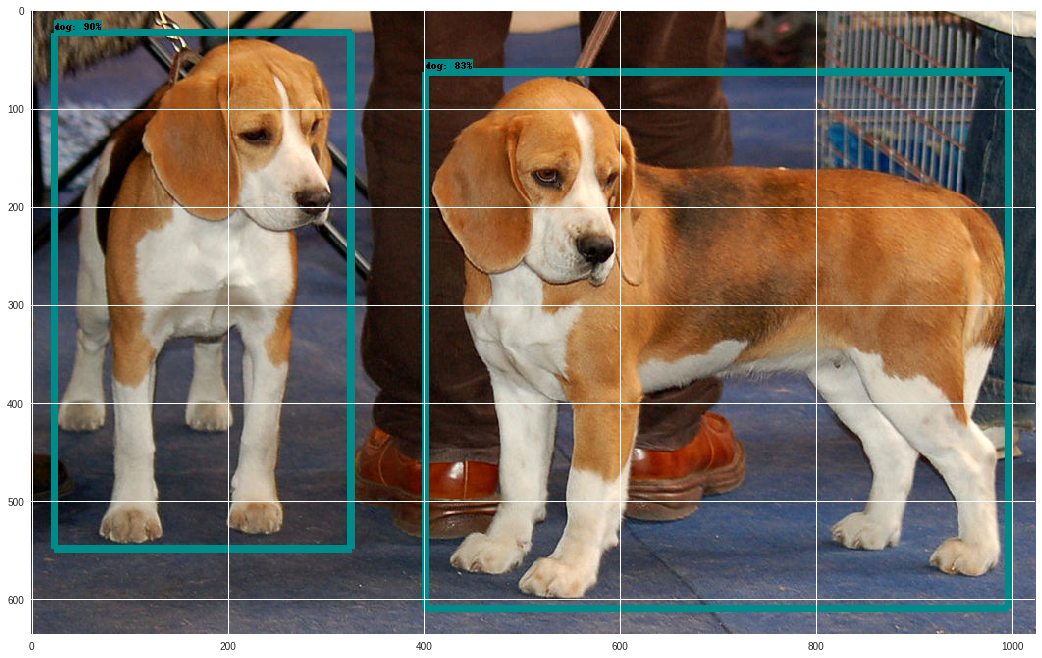

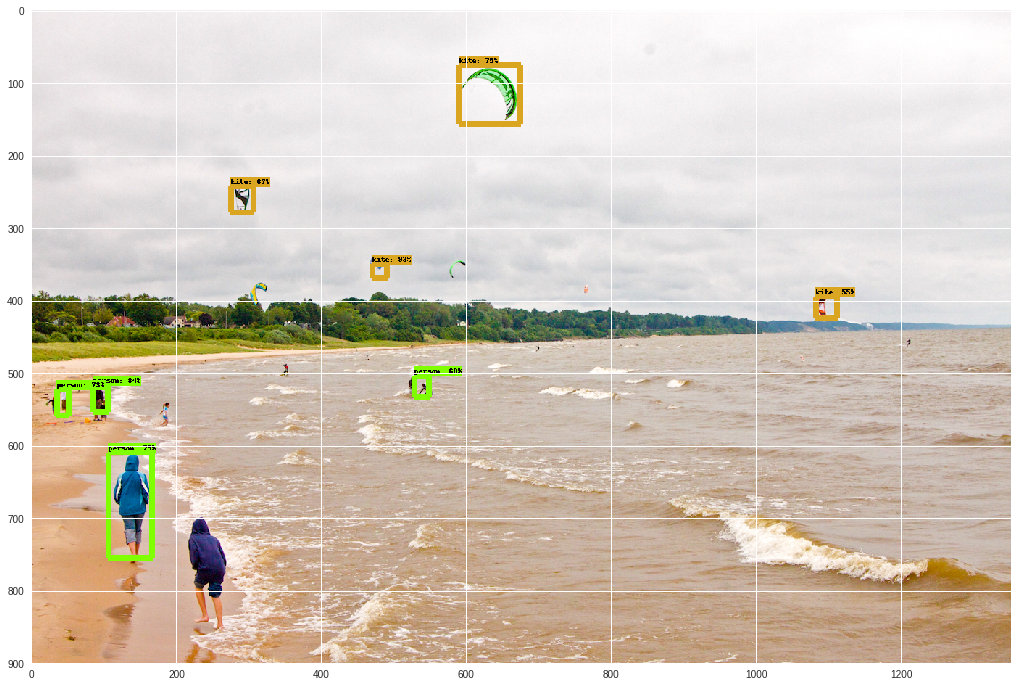

In [66]:
# SSD推論処理の実行

# テスト画像パス読み込み
for image_path in TEST_IMAGE_PATHS:
  # 画像の読み込み
  image = Image.open(image_path)
  # 画像をnumpy配列に変換
  image_np = load_image_into_numpy_array(image)
  # 画像データの0次元目を追加(バッチ分の次元)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # 推論処理の実行
  # 戻り値として辞書に登録したkeyの出力を得る
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # ユーティリティ関数を使用して可視化
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,                                         # numpy配列の画像データ
      output_dict['detection_boxes'],   # 検出されたbbox
      output_dict['detection_classes'], # 検出されたbboxのクラス
      output_dict['detection_scores'],  # 検出されたbboxのスコア
      category_index,                               # カテゴリidとカテゴリ名の辞書　
      instance_masks=None,                   # segmentation用マスク（今回は不使用）
      use_normalized_coordinates=True, # 画像サイズで規格化されたbbox位置(ymin, xmin, ymax, xmax)
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [68]:
# output_dictを個々に出力
# 例：スコアが0.5以上の検出結果
for i in range(len(output_dict['detection_classes'])):
  if output_dict['detection_scores'][i] > 0.5:
    print(category_index[output_dict['detection_classes'][i]]['name'],  # 検出されたクラス名
         output_dict['detection_scores'][i], # スコアの値
         np.array(output_dict['detection_boxes'][i].tolist()*np.array([x,y,x,y]), dtype='int') # 画像上のbox座標
         )

kite 0.9387724 [350 470 368 491]
person 0.8412665 [517  85 553 106]
person 0.7591448 [610 106 754 167]
kite 0.7577684 [ 76 590 156 675]
person 0.7347044 [523  35 558  52]
person 0.6840946 [504 528 532 549]
kite 0.67587715 [243 275 278 307]
kite 0.5513813 [ 395 1082  423 1112]
